This notebook provides the classification results for the room level analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import re
import ast
import pickle

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

% matplotlib inline

plt.rcParams['figure.figsize'] = 12, 8

In [4]:
## Importing the data

data_binary = pd.read_csv('data/room_level_data.csv').set_index('Unnamed: 0')
print data_binary.columns
print data_binary.shape

binarized_bld_type_dict = {'Monasteries':1, 'Mosques':0}
data_binary['bld_type_binary'] = data_binary['building_type'].apply(lambda x: binarized_bld_type_dict[x])

col_data = [col for col in data_binary.columns if col not in ['bld_type']]
data = data_binary[col_data]

print data.head(5)
print '\n'
print 'Proportion of Monasteries:', sum(data['bld_type_binary'])/float(data.shape[0])

Index([u'index_building', u'index_room', u'n_connections', u'area',
       u'isovistArea', u'building_type'],
      dtype='object')
(1569, 6)
            index_building  index_room  n_connections  area  isovistArea  \
Unnamed: 0                                                                 
0                        0           0              2  4769         2268   
1                        0           1             10  1363          719   
2                        0           2              5   832          712   
3                        0           3              2   415          435   
4                        0           4              5   290          785   

           building_type  bld_type_binary  
Unnamed: 0                                 
0                Mosques                0  
1                Mosques                0  
2                Mosques                0  
3                Mosques                0  
4                Mosques                0  


Proportion of M

In [5]:
## Dividing in training and testing

def splitOutcomeFunction(df, ycol=None):
    '''
    df is a pandas dataframe.
    '''

    if not isinstance(df, pd.DataFrame):
        raise ValueError('df is expected to be a pd.DataFrame,'
                         'it currently is' % (type(df)))

    if not ycol:
        ycol = df.columns[-1]

    col_sel = [x for x in df.columns if x != ycol]
    full_mat = df[col_sel]
    outcome_mat = df[ycol]

    return full_mat.as_matrix(), outcome_mat.as_matrix()

col_classification = ['n_connections', 'area', 'isovistArea', 'bld_type_binary']
data_classification = data[col_classification]
X_mat, y_vec = splitOutcomeFunction(data_classification, ycol='bld_type_binary')
X_train, X_test, y_train, y_test = train_test_split(X_mat, y_vec, test_size=0.33, random_state=7)

In [6]:
## Changing the area and isovistArea to log to improve spread and readability

data['n_connections_log'] = np.log10(data['n_connections'].values + 1)
data['area_log'] = np.log10(data['area'].values + 1)
data['isovistArea_log'] = np.log10(data['isovistArea'].values + 1)

### 3D Visualization of the Feature Space

In [7]:
%matplotlib widget

In [8]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = 12, 8

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

color = ['red' if not el else 'blue' for el in data['bld_type_binary'].values]
marker = ['v' if not el else 's' for el in data['bld_type_binary'].values]
label = ['Mosque' if not el else 'Monastery' for el in data['bld_type_binary'].values]

data_mon = data[data['bld_type_binary'] == 1]
data_mos = data[data['bld_type_binary'] == 0]

ax.scatter(data_mon['n_connections_log'],
           data_mon['area_log'],
           data_mon['isovistArea_log'],
           c='red',
           label='Monastery')
ax.scatter(data_mos['n_connections_log'],
           data_mos['area_log'],
           data_mos['isovistArea_log'],
           c='blue',
           label='Mosque')
ax.set_xlabel('Number of Connections (log10)', fontsize=12)
ax.set_ylabel('Area (log10)', fontsize=12)
ax.set_zlabel('Isovist Area (log10)', fontsize=12)
ax.set_title('Feature Space - Room Level Classification')
ax.legend()
plt.show()



FigureCanvasNbAgg()

## Room Level Classification

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss


model_fitting_dict_binary = {
    'Nearest Neighbours' : {
        'model': KNeighborsClassifier,
        'random_grid': {'n_neighbors': range(1,20)},
        'default': {'n_neighbors': 1},
        'optimize': True,
        'scale': True,
        'n_iter': 19
    },
    'Random Forest' : {
        'model': RandomForestClassifier,
        'random_grid': {'bootstrap': [True, False],
                         'max_depth': [10, 30, 50, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 350, 500, 1000]},
        'default': None,
        'optimize': True,
        'scale': True,
        'n_iter': 100
    },
    'Logistic Regression' : {
        'model': LogisticRegression,
        'random_grid': None,
        'default': {'multi_class':'ovr', 'solver':'saga', 'max_iter':1000},
        'optimize': False,
        'scale': True
    },
    'Logistic Regression - L1 Penalty' : {
        'model': LogisticRegression,
        'random_grid': None,
        'default': {'multi_class':'ovr', 'solver':'saga', 'max_iter':1000, 'penalty':'l1'},
        'optimize': False,
        'scale': True
    },
    'Gradient Boosted Trees' : {
        'model': XGBClassifier,
        'random_grid': {
                        'min_child_weight': [1, 5, 10, 20],
                        'gamma': [0.5, 1, 1.5, 2, 5],
                        'subsample': [0.6, 0.8, 1.0],
                        'colsample_bytree': [0.6, 0.8, 1.0],
                        'max_depth': [10, 50, 100, 200, 400]
                        },
        'default': None,
        'optimize': True,
        'scale': True,
        'n_iter': 100
    }
}

In [44]:
## Functions for classification

def merge_two_dicts(dict1, dict2):
    z = dict1.copy()  
    z.update(dict2) 
    return z


def fitting_model_from_dict(X_train, y_train, X_test, y_test, outcome_label = [0,1,2], 
                            opt_metric='accuracy', model_dict=model_fitting_dict_binary):
    
    scaler = StandardScaler()
    X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.fit_transform(X_test)
    out_list = []
    
    for model_name, model_value in model_dict.iteritems():
        out_model = []
        print 'Working on %s'%(model_name)
        
        # Fitting the model as is first
        if model_value['default']:
            model = model_value['model'](**model_value['default'])
        else:
            model = model_value['model']()
            
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        y_predict_dict = Counter(zip(y_test, y_predict))
        
        out_model.append(model_name)
        for class_label in outcome_label:
            out_model.append(y_predict_dict[(class_label, class_label)]/float(sum(y_test==class_label)))
        sum_correct = 0
        for class_label in outcome_label:
            sum_correct += y_predict_dict[(class_label, class_label)]
        out_model.append(sum_correct/float(len(y_test)))
        out_list.append(out_model)
        
        
        # Fitting the model scaled as necessary
        if model_value['scale']:
            out_model = []
            
            if model_value['default']:
                model = model_value['model'](**model_value['default'])
            else:
                model = model_value['model']()
            model.fit(X_train_scaled, y_train)
            y_predict = model.predict(X_test_scaled)
            y_predict_dict = Counter(zip(y_test, y_predict))

            out_model.append(model_name +' (Scaled)')
            for class_label in outcome_label:
                out_model.append(y_predict_dict[(class_label, class_label)]/float(sum(y_test==class_label)))
            sum_correct = 0
            for class_label in outcome_label:
                sum_correct += y_predict_dict[(class_label, class_label)]
            out_model.append(sum_correct/float(len(y_test)))
            out_list.append(out_model)
            
        # Optimize the model if necessary    
        if model_value['optimize']:
            out_model = []
            print 'Optimizing %s'%(model_name)
            
            if model_value['default']:
                model = model_value['model'](**model_value['default'])
            else:
                model = model_value['model']()
                
            print model_value
            
            random_grid = model_value['random_grid']
            random_opt = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid,
                               n_iter = model_value['n_iter'],
                               cv = 3, 
                               verbose=1, 
                               random_state=42, 
                               n_jobs = -1,
                               scoring = opt_metric)
            
            random_opt.fit(X_train, y_train)
            
            if model_value['default']:
                final_model_params_dict = merge_two_dicts(model_value['default'], random_opt.best_params_)
            else:
                final_model_params_dict = random_opt.best_params_
                
            model = model_value['model'](**final_model_params_dict)
            model.fit(X_train, y_train)
            y_predict = model.predict(X_test)
            y_predict_dict = Counter(zip(y_test, y_predict))

            out_model.append(model_name+' (Optimized)')
            for class_label in outcome_label:
                out_model.append(y_predict_dict[(class_label, class_label)]/float(sum(y_test==class_label)))
            sum_correct = 0
            for class_label in outcome_label:
                sum_correct += y_predict_dict[(class_label, class_label)]
            out_model.append(sum_correct/float(len(y_test)))
            out_list.append(out_model)
            
    return out_list

In [45]:
## Fitting it at a room level

output_list_models_binary = fitting_model_from_dict(
    X_train, y_train, X_test, y_test,
    outcome_label = [0,1], model_dict=model_fitting_dict_binary)

Working on Nearest Neighbours
Optimizing Nearest Neighbours
{'n_iter': 19, 'scale': True, 'default': {'n_neighbors': 1}, 'random_grid': {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}, 'model': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'optimize': True}
Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.2s finished


Working on Logistic Regression - L1 Penalty
Working on Random Forest
Optimizing Random Forest
{'n_iter': 100, 'scale': True, 'default': None, 'random_grid': {'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [50, 100, 200, 350, 500, 1000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 30, 50, 100, None]}, 'model': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'optimize': True}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


Working on Logistic Regression
Working on Gradient Boosted Trees
Optimizing Gradient Boosted Trees
{'n_iter': 100, 'scale': True, 'default': None, 'random_grid': {'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'gamma': [0.5, 1, 1.5, 2, 5], 'min_child_weight': [1, 5, 10, 20], 'max_depth': [10, 50, 100, 200, 400]}, 'model': <class 'xgboost.sklearn.XGBClassifier'>, 'optimize': True}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/NicDalmasso/.virtualenvs/astropy/lib/python2.7/site-packages/sklearn/preprocessing/labe

In [47]:
random_class_acc = sum(data['bld_type_binary']==0)/float(data.shape[0])
print random_class_acc

for line in output_list_models_binary:
    model_name, class0_acc, class1_acc, total_acc = line
    print model_name, round(total_acc*100, 2), round(random_class_acc*100, 2), round(100*(total_acc - random_class_acc)/random_class_acc, 2)

0.536647546208
Nearest Neighbours 67.57 53.66 25.91
Nearest Neighbours (Scaled) 59.07 53.66 10.08
Nearest Neighbours (Optimized) 67.37 53.66 25.55
Logistic Regression - L1 Penalty 55.6 53.66 3.6
Logistic Regression - L1 Penalty (Scaled) 55.41 53.66 3.24
Random Forest 70.85 53.66 32.02
Random Forest (Scaled) 58.88 53.66 9.72
Random Forest (Optimized) 72.2 53.66 34.54
Logistic Regression 55.6 53.66 3.6
Logistic Regression (Scaled) 55.41 53.66 3.24
Gradient Boosted Trees 68.34 53.66 27.35
Gradient Boosted Trees (Scaled) 61.78 53.66 15.11
Gradient Boosted Trees (Optimized) 69.11 53.66 28.78


In [11]:
## Saving the results as a pickle file

from datetime import datetime

filename_out = 'processed_dict/output_list_results_binary_roomlevel_%s.pkl'%(datetime.strftime(datetime.today(), format='%Y-%m-%d'))
pickle.dump(output_list_models_binary, open(filename_out, 'wb'))

## Investigate what happens in XGBOOST/RF

In [124]:
import warnings

best_model_dict = {'Random Forest' : {
        'model': RandomForestClassifier,
        'random_grid': {'bootstrap': [True, False],
                         'max_depth': [10, 30, 50, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 350, 500, 1000]},
        'default': {'random_state':7},
        'optimize': False,
        'scale': False,
        'n_iter': 100
    }}

model_value = best_model_dict['Random Forest']
if model_value['optimize']:
    print 'Optimizing %s'%(model_name)

    if model_value['default']:
        model = model_value['model'](**model_value['default'])
    else:
        model = model_value['model']()

    print model_value

    random_grid = model_value['random_grid']
    random_opt = RandomizedSearchCV(estimator = model, 
                       param_distributions = random_grid,
                       n_iter = model_value['n_iter'],
                       cv = 3, 
                       verbose=1, 
                       random_state=42, 
                       n_jobs = -1,
                       scoring = 'accuracy')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        random_opt.fit(X_train, y_train)

    if model_value['default']:
        final_model_params_dict = merge_two_dicts(model_value['default'], random_opt.best_params_)
    else:
        final_model_params_dict = random_opt.best_params_

    model = model_value['model'](**final_model_params_dict)
    model.fit(X_train, y_train)
else:
    if model_value['default']:
        model = model_value['model'](**model_value['default'])
    else:
        model = model_value['model']()

    model.fit(X_train, y_train)
    

In [125]:
## How does it work at predicting which graph is it?

model_value = best_model_dict['Random Forest']
predict_dict = {'Mosques': [[], []], 'Monasteries':[[], []]}
for building_type in predict_dict.keys():
    building_idx_list = data_binary[data_binary['building_type'] == building_type]['index_building'].unique()
    
    for building_idx in building_idx_list:
        true_label = 0 if building_type == 'Mosques' else 1
        
        data_temp = data_binary[~((data_binary['building_type'] == building_type) & (data_binary['index_building'] == building_idx))]
        feat_col_classification = ['n_connections', 'area', 'isovistArea']
        output_col_classification = 'bld_type_binary'
        X_mat_temp = data_temp[feat_col_classification].as_matrix()
        y_vec_temp = data_temp[output_col_classification].as_matrix()


        if model_value['default']:
            model = model_value['model'](**model_value['default'])
        else:
            model = model_value['model']()

        model.fit(X_mat_temp, y_vec_temp)
        
        data_out_temp = data_binary[(data_binary['building_type'] == building_type) & (data_binary['index_building'] == building_idx)]
        X_test_temp = data_out_temp[feat_col_classification].as_matrix()
        predictions = model.predict(X_test_temp)
        
        predict_dict[building_type][0].append(true_label)
        predict_dict[building_type][1].append(0 if np.average(predictions) <= 0.5 else 1)        

In [126]:
from sklearn.metrics import accuracy_score

true_label_final = predict_dict['Monasteries'][0] + predict_dict['Mosques'][0]
predicted_label_final = predict_dict['Monasteries'][1] + predict_dict['Mosques'][1]

print accuracy_score(y_true=true_label_final, y_pred=predicted_label_final)


0.6666666666666666


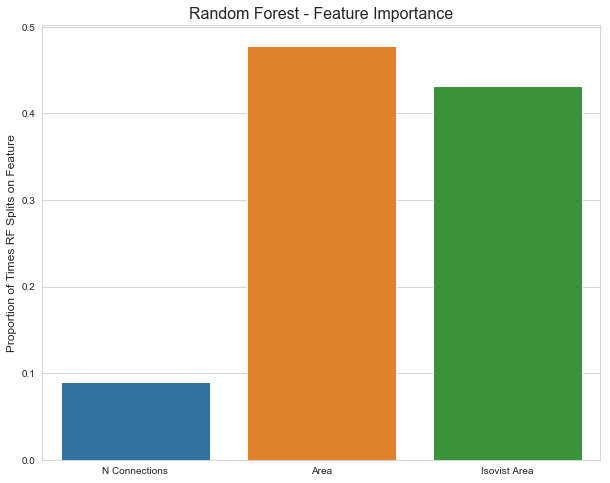

In [31]:
## Feature Importances
feature_vec = ['N Connections', 'Area', 'Isovist Area']

plt.rcParams['figure.figsize'] = 10, 8
sns.set_style("whitegrid")

sns.barplot(y=model.feature_importances_, x=feature_vec)
plt.ylabel('Proportion of Times RF Splits on Feature', fontsize=12)
plt.title('Random Forest - Feature Importance', fontsize=16)
plt.show()

In [23]:
import xgboost as xgb
import warnings

def partial_dependency(bst, X, y, f_id, n_grid = 100):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    Function taken from https://www.kaggle.com/chalkalan/xgboost-tutorial-var-imp-partial-dependence
    """

    X_temp = X.copy()

    grid = np.linspace(np.percentile(X_temp[:, f_id], 0.1),
                       np.percentile(X_temp[:, f_id], 99.5),
                       n_grid)
    y_pred = np.zeros(len(grid))

    for i, val in enumerate(grid):

        X_temp[:, f_id] = val

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y_pred[i] = np.average(bst.predict(X_temp))

    return grid, y_pred

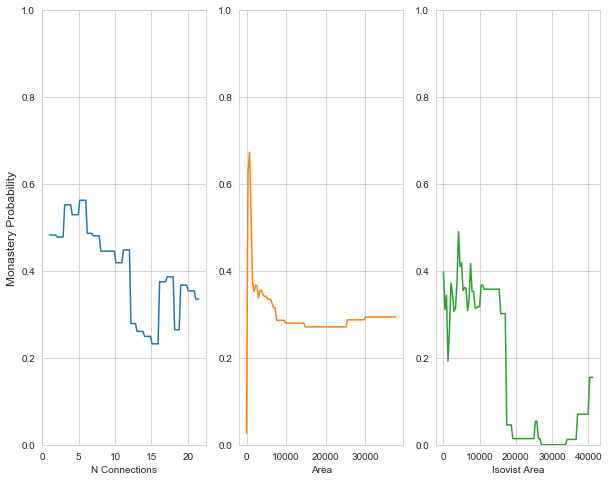

In [32]:
feature_vec = ['N Connections', 'Area', 'Isovist Area']
number_of_columns = 3
number_of_rows = (len(feature_vec) / number_of_columns)
number_of_subplots = len(feature_vec)

color_palette = sns.color_palette("tab10", 10)

for j, feature in enumerate(feature_vec):
    grid, y_pred = partial_dependency(bst=model, X=X_train, y=y_train, f_id = j)
    ax1 = plt.subplot(number_of_rows, number_of_columns, j + 1)
    ax1.plot(grid, y_pred, color=color_palette[j])
    ax1.set_xlabel(feature)
    if (j+1) % number_of_columns == 1:
        ax1.set_ylabel('Monastery Probability', fontsize=12)
    ax1.set_ylim([0,1])   
plt.show()